In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 nrr31vzi


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-nrr31vzi:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:10.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                         | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                                 | 1/1186 [00:02<43:34,  2.21s/it]

  0%|▍                                                                                                                | 5/1186 [00:02<06:53,  2.86it/s]

  1%|▉                                                                                                               | 10/1186 [00:02<03:00,  6.53it/s]

  1%|█▍                                                                                                              | 15/1186 [00:02<01:47, 10.91it/s]

  2%|█▉                                                                                                              | 20/1186 [00:02<01:13, 15.82it/s]

  2%|██▎                                                                                                             | 25/1186 [00:02<00:55, 20.99it/s]

  3%|██▊                                                                                                             | 30/1186 [00:02<00:44, 26.14it/s]

  3%|███▎                                                                                                            | 35/1186 [00:02<00:37, 30.94it/s]

  3%|███▊                                                                                                            | 40/1186 [00:03<00:32, 35.17it/s]

  4%|████▏                                                                                                           | 45/1186 [00:03<00:29, 38.70it/s]

  4%|████▋                                                                                                           | 50/1186 [00:03<00:27, 41.55it/s]

  5%|█████▏                                                                                                          | 55/1186 [00:03<00:25, 43.76it/s]

  5%|█████▋                                                                                                          | 60/1186 [00:03<00:24, 45.41it/s]

  5%|██████▏                                                                                                         | 65/1186 [00:03<00:24, 46.64it/s]

  6%|██████▌                                                                                                         | 70/1186 [00:03<00:23, 47.36it/s]

  6%|███████                                                                                                         | 75/1186 [00:03<00:23, 48.04it/s]

  7%|███████▌                                                                                                        | 80/1186 [00:03<00:22, 48.41it/s]

  7%|████████                                                                                                        | 85/1186 [00:03<00:22, 48.77it/s]

  8%|████████▍                                                                                                       | 90/1186 [00:04<00:22, 49.08it/s]

  8%|████████▉                                                                                                       | 95/1186 [00:04<00:22, 49.27it/s]

  8%|█████████▎                                                                                                     | 100/1186 [00:04<00:21, 49.39it/s]

  9%|█████████▊                                                                                                     | 105/1186 [00:04<00:21, 49.45it/s]

  9%|██████████▎                                                                                                    | 110/1186 [00:04<00:21, 49.54it/s]

 10%|██████████▊                                                                                                    | 115/1186 [00:04<00:21, 49.59it/s]

 10%|███████████▏                                                                                                   | 120/1186 [00:04<00:21, 49.53it/s]

 11%|███████████▋                                                                                                   | 125/1186 [00:04<00:21, 49.45it/s]

 11%|████████████▏                                                                                                  | 130/1186 [00:04<00:21, 49.41it/s]

 11%|████████████▋                                                                                                  | 135/1186 [00:04<00:21, 49.39it/s]

 12%|█████████████                                                                                                  | 140/1186 [00:05<00:21, 49.27it/s]

 12%|█████████████▌                                                                                                 | 145/1186 [00:05<00:21, 49.30it/s]

 13%|██████████████                                                                                                 | 150/1186 [00:05<00:21, 49.33it/s]

 13%|██████████████▌                                                                                                | 155/1186 [00:05<00:20, 49.40it/s]

 13%|██████████████▉                                                                                                | 160/1186 [00:05<00:20, 49.46it/s]

 14%|███████████████▍                                                                                               | 165/1186 [00:05<00:20, 49.50it/s]

 14%|███████████████▉                                                                                               | 170/1186 [00:05<00:20, 49.52it/s]

 15%|████████████████▍                                                                                              | 175/1186 [00:05<00:20, 49.35it/s]

 15%|████████████████▊                                                                                              | 180/1186 [00:05<00:20, 49.38it/s]

 16%|█████████████████▎                                                                                             | 185/1186 [00:05<00:20, 49.44it/s]

 16%|█████████████████▊                                                                                             | 190/1186 [00:06<00:20, 49.43it/s]

 16%|██████████████████▎                                                                                            | 195/1186 [00:06<00:20, 49.38it/s]

 17%|██████████████████▋                                                                                            | 200/1186 [00:06<00:19, 49.47it/s]

 17%|███████████████████▏                                                                                           | 205/1186 [00:06<00:19, 49.55it/s]

 18%|███████████████████▋                                                                                           | 210/1186 [00:06<00:19, 49.63it/s]

 18%|████████████████████                                                                                           | 215/1186 [00:06<00:19, 49.67it/s]

 19%|████████████████████▌                                                                                          | 220/1186 [00:06<00:19, 49.73it/s]

 19%|█████████████████████                                                                                          | 225/1186 [00:06<00:19, 49.68it/s]

 19%|█████████████████████▌                                                                                         | 230/1186 [00:06<00:19, 49.71it/s]

 20%|█████████████████████▉                                                                                         | 235/1186 [00:06<00:19, 49.74it/s]

 20%|██████████████████████▍                                                                                        | 240/1186 [00:07<00:19, 49.75it/s]

 21%|██████████████████████▉                                                                                        | 245/1186 [00:07<00:18, 49.76it/s]

 21%|███████████████████████▍                                                                                       | 250/1186 [00:07<00:18, 49.58it/s]

 22%|███████████████████████▊                                                                                       | 255/1186 [00:07<00:18, 49.61it/s]

 22%|████████████████████████▎                                                                                      | 260/1186 [00:07<00:18, 49.63it/s]

 22%|████████████████████████▊                                                                                      | 265/1186 [00:07<00:18, 49.67it/s]

 23%|█████████████████████████▎                                                                                     | 270/1186 [00:07<00:18, 49.71it/s]

 23%|█████████████████████████▋                                                                                     | 275/1186 [00:07<00:18, 49.72it/s]

 24%|██████████████████████████▏                                                                                    | 280/1186 [00:07<00:18, 49.58it/s]

 24%|██████████████████████████▋                                                                                    | 285/1186 [00:07<00:18, 49.59it/s]

 24%|███████████████████████████▏                                                                                   | 290/1186 [00:08<00:18, 49.65it/s]

 25%|███████████████████████████▌                                                                                   | 295/1186 [00:08<00:17, 49.66it/s]

 25%|████████████████████████████                                                                                   | 300/1186 [00:08<00:17, 49.50it/s]

 26%|████████████████████████████▌                                                                                  | 305/1186 [00:08<00:17, 49.55it/s]

 26%|█████████████████████████████                                                                                  | 310/1186 [00:08<00:17, 49.60it/s]

 27%|█████████████████████████████▍                                                                                 | 315/1186 [00:08<00:17, 49.67it/s]

 27%|█████████████████████████████▉                                                                                 | 320/1186 [00:08<00:17, 49.70it/s]

 27%|██████████████████████████████▍                                                                                | 325/1186 [00:08<00:17, 49.74it/s]

 28%|██████████████████████████████▉                                                                                | 330/1186 [00:08<00:17, 49.68it/s]

 28%|███████████████████████████████▎                                                                               | 335/1186 [00:08<00:17, 49.51it/s]

 29%|███████████████████████████████▊                                                                               | 340/1186 [00:09<00:17, 49.43it/s]

 29%|████████████████████████████████▎                                                                              | 345/1186 [00:09<00:17, 49.41it/s]

 30%|████████████████████████████████▊                                                                              | 350/1186 [00:09<00:16, 49.40it/s]

 30%|█████████████████████████████████▏                                                                             | 355/1186 [00:09<00:16, 49.22it/s]

 30%|█████████████████████████████████▋                                                                             | 360/1186 [00:09<00:16, 49.26it/s]

 31%|██████████████████████████████████▏                                                                            | 365/1186 [00:09<00:16, 49.11it/s]

 31%|██████████████████████████████████▋                                                                            | 370/1186 [00:09<00:16, 48.98it/s]

 32%|███████████████████████████████████                                                                            | 375/1186 [00:09<00:16, 48.91it/s]

 32%|███████████████████████████████████▌                                                                           | 380/1186 [00:09<00:16, 49.02it/s]

 32%|████████████████████████████████████                                                                           | 385/1186 [00:10<00:16, 48.89it/s]

 33%|████████████████████████████████████▌                                                                          | 390/1186 [00:10<00:16, 48.83it/s]

 33%|████████████████████████████████████▉                                                                          | 395/1186 [00:10<00:16, 48.82it/s]

 34%|█████████████████████████████████████▍                                                                         | 400/1186 [00:10<00:16, 48.75it/s]

 34%|█████████████████████████████████████▉                                                                         | 405/1186 [00:10<00:15, 48.91it/s]

 35%|██████████████████████████████████████▎                                                                        | 410/1186 [00:10<00:15, 48.89it/s]

 35%|██████████████████████████████████████▊                                                                        | 415/1186 [00:10<00:15, 48.83it/s]

 35%|███████████████████████████████████████▎                                                                       | 420/1186 [00:10<00:15, 48.87it/s]

 36%|███████████████████████████████████████▊                                                                       | 425/1186 [00:10<00:15, 49.08it/s]

 36%|████████████████████████████████████████▏                                                                      | 430/1186 [00:10<00:15, 49.24it/s]

 37%|████████████████████████████████████████▋                                                                      | 435/1186 [00:11<00:15, 49.11it/s]

 37%|█████████████████████████████████████████▏                                                                     | 440/1186 [00:11<00:15, 49.14it/s]

 38%|█████████████████████████████████████████▋                                                                     | 445/1186 [00:11<00:15, 49.25it/s]

 38%|██████████████████████████████████████████                                                                     | 450/1186 [00:11<00:14, 49.31it/s]

 38%|██████████████████████████████████████████▌                                                                    | 455/1186 [00:11<00:14, 49.37it/s]

 39%|███████████████████████████████████████████                                                                    | 460/1186 [00:11<00:14, 49.42it/s]

 39%|███████████████████████████████████████████▌                                                                   | 465/1186 [00:11<00:14, 49.44it/s]

 40%|███████████████████████████████████████████▉                                                                   | 470/1186 [00:11<00:14, 49.35it/s]

 40%|████████████████████████████████████████████▍                                                                  | 475/1186 [00:11<00:14, 49.40it/s]

 40%|████████████████████████████████████████████▉                                                                  | 480/1186 [00:11<00:14, 49.42it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 485/1186 [00:12<00:14, 49.44it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 490/1186 [00:12<00:14, 49.44it/s]

 42%|██████████████████████████████████████████████▎                                                                | 495/1186 [00:12<00:13, 49.45it/s]

 42%|██████████████████████████████████████████████▊                                                                | 500/1186 [00:12<00:13, 49.48it/s]

 43%|███████████████████████████████████████████████▎                                                               | 505/1186 [00:12<00:13, 49.47it/s]

 43%|███████████████████████████████████████████████▋                                                               | 510/1186 [00:12<00:13, 49.44it/s]

 43%|████████████████████████████████████████████████▏                                                              | 515/1186 [00:12<00:13, 49.58it/s]

 44%|████████████████████████████████████████████████▋                                                              | 520/1186 [00:12<00:13, 49.46it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 525/1186 [00:12<00:13, 49.47it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 530/1186 [00:12<00:13, 49.31it/s]

 45%|██████████████████████████████████████████████████                                                             | 535/1186 [00:13<00:13, 49.36it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 540/1186 [00:13<00:13, 49.38it/s]

 46%|███████████████████████████████████████████████████                                                            | 545/1186 [00:13<00:12, 49.39it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 550/1186 [00:13<00:12, 49.44it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 555/1186 [00:13<00:12, 49.49it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 560/1186 [00:13<00:12, 49.44it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 565/1186 [00:13<00:12, 49.43it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 570/1186 [00:13<00:12, 49.43it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 575/1186 [00:13<00:12, 49.25it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 581/1186 [00:13<00:12, 49.48it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 586/1186 [00:14<00:12, 49.55it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 591/1186 [00:14<00:12, 49.54it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 596/1186 [00:14<00:11, 49.51it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 601/1186 [00:14<00:11, 49.55it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 606/1186 [00:14<00:11, 49.57it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 611/1186 [00:14<00:11, 49.56it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 616/1186 [00:14<00:11, 49.48it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 621/1186 [00:14<00:11, 49.52it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 626/1186 [00:14<00:11, 49.55it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 631/1186 [00:14<00:11, 49.56it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 636/1186 [00:15<00:11, 49.56it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 641/1186 [00:15<00:11, 49.43it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 646/1186 [00:15<00:10, 49.38it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 651/1186 [00:15<00:10, 49.46it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 656/1186 [00:15<00:10, 49.51it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 661/1186 [00:15<00:10, 49.56it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 666/1186 [00:15<00:10, 49.55it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 671/1186 [00:15<00:10, 49.32it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 676/1186 [00:15<00:10, 49.35it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 681/1186 [00:15<00:10, 49.36it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 686/1186 [00:16<00:10, 49.44it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 691/1186 [00:16<00:10, 49.33it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 696/1186 [00:16<00:09, 49.39it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 701/1186 [00:16<00:09, 49.43it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 706/1186 [00:16<00:09, 49.48it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 711/1186 [00:16<00:09, 49.51it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 716/1186 [00:16<00:09, 49.54it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 721/1186 [00:16<00:09, 49.56it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 726/1186 [00:16<00:09, 49.58it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 731/1186 [00:17<00:09, 49.38it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 736/1186 [00:17<00:09, 49.46it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 741/1186 [00:17<00:08, 49.53it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 746/1186 [00:17<00:08, 49.57it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 751/1186 [00:17<00:08, 49.54it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 756/1186 [00:17<00:08, 49.58it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 761/1186 [00:17<00:08, 49.58it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 766/1186 [00:17<00:08, 49.61it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 771/1186 [00:17<00:08, 49.62it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 776/1186 [00:17<00:08, 49.44it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 781/1186 [00:18<00:08, 49.45it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 786/1186 [00:18<00:08, 49.51it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 791/1186 [00:18<00:07, 49.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 796/1186 [00:18<00:07, 49.44it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 801/1186 [00:18<00:07, 49.49it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 806/1186 [00:18<00:07, 49.52it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 811/1186 [00:18<00:07, 49.54it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 816/1186 [00:18<00:07, 49.55it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 821/1186 [00:18<00:07, 49.59it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 826/1186 [00:18<00:07, 49.63it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 831/1186 [00:19<00:07, 49.62it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 836/1186 [00:19<00:07, 49.59it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 841/1186 [00:19<00:06, 49.61it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 846/1186 [00:19<00:06, 49.59it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 851/1186 [00:19<00:06, 49.46it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 856/1186 [00:19<00:06, 49.46it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 861/1186 [00:19<00:06, 49.51it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 866/1186 [00:19<00:06, 49.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 871/1186 [00:19<00:06, 49.56it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 876/1186 [00:19<00:06, 49.59it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 882/1186 [00:20<00:06, 50.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 888/1186 [00:20<00:05, 50.47it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 894/1186 [00:20<00:05, 50.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 900/1186 [00:20<00:05, 51.08it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 906/1186 [00:20<00:05, 51.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 912/1186 [00:20<00:05, 51.24it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 918/1186 [00:20<00:05, 51.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 924/1186 [00:20<00:05, 51.12it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 930/1186 [00:20<00:05, 50.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 936/1186 [00:21<00:04, 50.41it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 942/1186 [00:21<00:04, 50.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 948/1186 [00:21<00:04, 49.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 953/1186 [00:21<00:04, 48.67it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 958/1186 [00:21<00:04, 48.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 963/1186 [00:21<00:04, 49.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 968/1186 [00:21<00:04, 49.25it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 973/1186 [00:21<00:04, 49.34it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 978/1186 [00:21<00:04, 49.40it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 983/1186 [00:22<00:04, 49.45it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 988/1186 [00:22<00:04, 49.48it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 993/1186 [00:22<00:03, 49.50it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 998/1186 [00:22<00:03, 49.37it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                 | 1003/1186 [00:22<00:03, 49.41it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▍                | 1008/1186 [00:22<00:03, 49.45it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                | 1013/1186 [00:22<00:03, 49.45it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▍               | 1018/1186 [00:22<00:03, 49.47it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉               | 1023/1186 [00:22<00:03, 49.49it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎              | 1028/1186 [00:22<00:03, 49.51it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▊              | 1033/1186 [00:23<00:03, 49.51it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1038/1186 [00:23<00:03, 49.18it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1044/1186 [00:23<00:02, 49.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1049/1186 [00:23<00:02, 49.50it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1054/1186 [00:23<00:02, 49.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1059/1186 [00:23<00:02, 49.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1064/1186 [00:23<00:02, 49.47it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1069/1186 [00:23<00:02, 49.44it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1074/1186 [00:23<00:02, 49.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████          | 1079/1186 [00:24<00:02, 49.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1084/1186 [00:24<00:02, 49.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████         | 1089/1186 [00:24<00:01, 49.37it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1094/1186 [00:24<00:01, 49.33it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1099/1186 [00:24<00:01, 49.31it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1104/1186 [00:24<00:01, 49.41it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1109/1186 [00:24<00:01, 49.46it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1114/1186 [00:24<00:01, 49.48it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1119/1186 [00:24<00:01, 49.51it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1124/1186 [00:24<00:01, 49.37it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1129/1186 [00:25<00:01, 49.36it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1134/1186 [00:25<00:01, 49.40it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1139/1186 [00:25<00:00, 49.39it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1144/1186 [00:25<00:00, 49.44it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1149/1186 [00:25<00:00, 49.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1154/1186 [00:25<00:00, 49.39it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1159/1186 [00:25<00:00, 49.43it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1164/1186 [00:25<00:00, 49.47it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1169/1186 [00:25<00:00, 49.42it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1174/1186 [00:25<00:00, 49.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1179/1186 [00:26<00:00, 49.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1184/1186 [00:26<00:00, 49.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:26<00:00, 45.21it/s]

train - OK


  0%|                                                                                                                          | 0/297 [00:00<?, ?it/s]

  0%|▍                                                                                                                 | 1/297 [00:00<01:07,  4.41it/s]

  2%|██▎                                                                                                               | 6/297 [00:00<00:13, 21.78it/s]

  4%|████▏                                                                                                            | 11/297 [00:00<00:09, 31.41it/s]

  5%|██████                                                                                                           | 16/297 [00:00<00:07, 37.49it/s]

  7%|███████▉                                                                                                         | 21/297 [00:00<00:06, 41.39it/s]

  9%|█████████▉                                                                                                       | 26/297 [00:00<00:06, 43.92it/s]

 10%|███████████▊                                                                                                     | 31/297 [00:00<00:05, 45.55it/s]

 12%|█████████████▋                                                                                                   | 36/297 [00:00<00:05, 46.77it/s]

 14%|███████████████▌                                                                                                 | 41/297 [00:01<00:05, 47.62it/s]

 15%|█████████████████▌                                                                                               | 46/297 [00:01<00:05, 48.21it/s]

 17%|███████████████████▍                                                                                             | 51/297 [00:01<00:05, 48.62it/s]

 19%|█████████████████████▎                                                                                           | 56/297 [00:01<00:04, 48.90it/s]

 21%|███████████████████████▏                                                                                         | 61/297 [00:01<00:04, 49.08it/s]

 22%|█████████████████████████                                                                                        | 66/297 [00:01<00:04, 49.22it/s]

 24%|███████████████████████████                                                                                      | 71/297 [00:01<00:04, 49.20it/s]

 26%|████████████████████████████▉                                                                                    | 76/297 [00:01<00:04, 49.32it/s]

 27%|██████████████████████████████▊                                                                                  | 81/297 [00:01<00:04, 49.43it/s]

 29%|████████████████████████████████▋                                                                                | 86/297 [00:01<00:04, 49.45it/s]

 31%|██████████████████████████████████▌                                                                              | 91/297 [00:02<00:04, 49.46it/s]

 32%|████████████████████████████████████▌                                                                            | 96/297 [00:02<00:04, 49.48it/s]

 34%|██████████████████████████████████████                                                                          | 101/297 [00:02<00:03, 49.53it/s]

 36%|███████████████████████████████████████▉                                                                        | 106/297 [00:02<00:03, 49.52it/s]

 37%|█████████████████████████████████████████▊                                                                      | 111/297 [00:02<00:03, 49.51it/s]

 39%|███████████████████████████████████████████▋                                                                    | 116/297 [00:02<00:03, 49.50it/s]

 41%|█████████████████████████████████████████████▋                                                                  | 121/297 [00:02<00:03, 49.51it/s]

 42%|███████████████████████████████████████████████▌                                                                | 126/297 [00:02<00:03, 49.39it/s]

 44%|█████████████████████████████████████████████████▍                                                              | 131/297 [00:02<00:03, 49.42it/s]

 46%|███████████████████████████████████████████████████▎                                                            | 136/297 [00:02<00:03, 49.45it/s]

 47%|█████████████████████████████████████████████████████▏                                                          | 141/297 [00:03<00:03, 49.47it/s]

 49%|███████████████████████████████████████████████████████                                                         | 146/297 [00:03<00:03, 49.48it/s]

 51%|████████████████████████████████████████████████████████▉                                                       | 151/297 [00:03<00:02, 49.53it/s]

 53%|██████████████████████████████████████████████████████████▊                                                     | 156/297 [00:03<00:02, 49.54it/s]

 54%|████████████████████████████████████████████████████████████▋                                                   | 161/297 [00:03<00:02, 49.54it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                 | 166/297 [00:03<00:02, 49.39it/s]

 58%|████████████████████████████████████████████████████████████████▍                                               | 171/297 [00:03<00:02, 49.43it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                             | 176/297 [00:03<00:02, 49.46it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                           | 181/297 [00:03<00:02, 49.48it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                         | 186/297 [00:03<00:02, 49.40it/s]

 64%|████████████████████████████████████████████████████████████████████████                                        | 191/297 [00:04<00:02, 49.41it/s]

 66%|█████████████████████████████████████████████████████████████████████████▉                                      | 196/297 [00:04<00:02, 49.31it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                    | 201/297 [00:04<00:01, 49.42it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 206/297 [00:04<00:01, 49.48it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▌                                | 211/297 [00:04<00:01, 49.52it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                              | 216/297 [00:04<00:01, 49.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                            | 221/297 [00:04<00:01, 49.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▏                          | 226/297 [00:04<00:01, 49.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                         | 231/297 [00:04<00:01, 49.51it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                       | 236/297 [00:04<00:01, 49.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 241/297 [00:05<00:01, 49.41it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▊                   | 246/297 [00:05<00:01, 49.47it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                 | 251/297 [00:05<00:00, 49.46it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▌               | 256/297 [00:05<00:00, 49.51it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 261/297 [00:05<00:00, 49.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 266/297 [00:05<00:00, 49.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 271/297 [00:05<00:00, 49.52it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████        | 276/297 [00:05<00:00, 49.51it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 281/297 [00:05<00:00, 49.48it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 286/297 [00:05<00:00, 49.62it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 291/297 [00:06<00:00, 49.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 296/297 [00:06<00:00, 49.64it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:06<00:00, 46.42it/s]

val - OK


  0%|                                                                                                                          | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                 | 1/437 [00:00<01:49,  3.98it/s]

  1%|█▌                                                                                                                | 6/437 [00:00<00:21, 20.31it/s]

  3%|██▊                                                                                                              | 11/437 [00:00<00:14, 30.24it/s]

  4%|████▏                                                                                                            | 16/437 [00:00<00:11, 36.55it/s]

  5%|█████▍                                                                                                           | 21/437 [00:00<00:10, 40.69it/s]

  6%|██████▋                                                                                                          | 26/437 [00:00<00:09, 43.41it/s]

  7%|████████                                                                                                         | 31/437 [00:00<00:08, 45.29it/s]

  8%|█████████▎                                                                                                       | 36/437 [00:00<00:08, 46.58it/s]

  9%|██████████▌                                                                                                      | 41/437 [00:01<00:08, 47.50it/s]

 11%|███████████▉                                                                                                     | 46/437 [00:01<00:08, 48.00it/s]

 12%|█████████████▏                                                                                                   | 51/437 [00:01<00:07, 48.41it/s]

 13%|██████████████▍                                                                                                  | 56/437 [00:01<00:07, 48.76it/s]

 14%|███████████████▊                                                                                                 | 61/437 [00:01<00:07, 49.04it/s]

 15%|█████████████████                                                                                                | 66/437 [00:01<00:07, 49.21it/s]

 16%|██████████████████▎                                                                                              | 71/437 [00:01<00:07, 49.32it/s]

 17%|███████████████████▋                                                                                             | 76/437 [00:01<00:07, 49.41it/s]

 19%|████████████████████▉                                                                                            | 81/437 [00:01<00:07, 49.44it/s]

 20%|██████████████████████▏                                                                                          | 86/437 [00:01<00:07, 49.44it/s]

 21%|███████████████████████▌                                                                                         | 91/437 [00:02<00:06, 49.48it/s]

 22%|████████████████████████▊                                                                                        | 96/437 [00:02<00:06, 49.53it/s]

 23%|█████████████████████████▉                                                                                      | 101/437 [00:02<00:06, 49.47it/s]

 24%|███████████████████████████▏                                                                                    | 106/437 [00:02<00:06, 49.21it/s]

 25%|████████████████████████████▍                                                                                   | 111/437 [00:02<00:06, 49.22it/s]

 27%|█████████████████████████████▋                                                                                  | 116/437 [00:02<00:06, 49.28it/s]

 28%|███████████████████████████████                                                                                 | 121/437 [00:02<00:06, 49.29it/s]

 29%|████████████████████████████████▎                                                                               | 126/437 [00:02<00:06, 49.24it/s]

 30%|█████████████████████████████████▌                                                                              | 131/437 [00:02<00:06, 49.23it/s]

 31%|██████████████████████████████████▊                                                                             | 136/437 [00:02<00:06, 49.17it/s]

 32%|████████████████████████████████████▏                                                                           | 141/437 [00:03<00:06, 49.26it/s]

 33%|█████████████████████████████████████▍                                                                          | 146/437 [00:03<00:05, 49.28it/s]

 35%|██████████████████████████████████████▋                                                                         | 151/437 [00:03<00:05, 49.28it/s]

 36%|███████████████████████████████████████▉                                                                        | 156/437 [00:03<00:05, 49.25it/s]

 37%|█████████████████████████████████████████▎                                                                      | 161/437 [00:03<00:05, 48.97it/s]

 38%|██████████████████████████████████████████▌                                                                     | 166/437 [00:03<00:05, 49.02it/s]

 39%|███████████████████████████████████████████▊                                                                    | 171/437 [00:03<00:05, 49.12it/s]

 40%|█████████████████████████████████████████████                                                                   | 176/437 [00:03<00:05, 49.21it/s]

 41%|██████████████████████████████████████████████▍                                                                 | 181/437 [00:03<00:05, 49.22it/s]

 43%|███████████████████████████████████████████████▋                                                                | 186/437 [00:04<00:05, 49.17it/s]

 44%|████████████████████████████████████████████████▉                                                               | 191/437 [00:04<00:05, 49.19it/s]

 45%|██████████████████████████████████████████████████▏                                                             | 196/437 [00:04<00:04, 49.19it/s]

 46%|███████████████████████████████████████████████████▌                                                            | 201/437 [00:04<00:04, 49.20it/s]

 47%|████████████████████████████████████████████████████▊                                                           | 206/437 [00:04<00:04, 49.29it/s]

 48%|██████████████████████████████████████████████████████                                                          | 211/437 [00:04<00:04, 49.33it/s]

 49%|███████████████████████████████████████████████████████▎                                                        | 216/437 [00:04<00:04, 49.38it/s]

 51%|████████████████████████████████████████████████████████▋                                                       | 221/437 [00:04<00:04, 49.22it/s]

 52%|█████████████████████████████████████████████████████████▉                                                      | 226/437 [00:04<00:04, 49.28it/s]

 53%|███████████████████████████████████████████████████████████▏                                                    | 231/437 [00:04<00:04, 49.34it/s]

 54%|████████████████████████████████████████████████████████████▍                                                   | 236/437 [00:05<00:04, 49.33it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 241/437 [00:05<00:03, 49.16it/s]

 56%|███████████████████████████████████████████████████████████████                                                 | 246/437 [00:05<00:03, 49.26it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 251/437 [00:05<00:03, 49.35it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                              | 256/437 [00:05<00:03, 49.36it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                             | 261/437 [00:05<00:03, 49.34it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                           | 266/437 [00:05<00:03, 49.09it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 271/437 [00:05<00:03, 49.21it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                         | 276/437 [00:05<00:03, 49.30it/s]

 64%|████████████████████████████████████████████████████████████████████████                                        | 281/437 [00:05<00:03, 49.18it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                      | 286/437 [00:06<00:03, 49.08it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                     | 291/437 [00:06<00:02, 49.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                    | 296/437 [00:06<00:02, 49.19it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                  | 301/437 [00:06<00:02, 49.24it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 306/437 [00:06<00:02, 49.31it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                | 311/437 [00:06<00:02, 49.33it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                               | 316/437 [00:06<00:02, 49.07it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                             | 321/437 [00:06<00:02, 49.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                            | 326/437 [00:06<00:02, 49.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                           | 331/437 [00:06<00:02, 49.26it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                          | 336/437 [00:07<00:02, 49.34it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▍                        | 341/437 [00:07<00:01, 49.37it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▋                       | 346/437 [00:07<00:01, 49.37it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 351/437 [00:07<00:01, 49.37it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                    | 356/437 [00:07<00:01, 49.38it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                   | 361/437 [00:07<00:01, 49.46it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                  | 366/437 [00:07<00:01, 49.44it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████                 | 371/437 [00:07<00:01, 49.41it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 376/437 [00:07<00:01, 49.43it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 381/437 [00:07<00:01, 49.43it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉             | 386/437 [00:08<00:01, 49.05it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 391/437 [00:08<00:00, 49.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 396/437 [00:08<00:00, 49.26it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 401/437 [00:08<00:00, 49.30it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████        | 406/437 [00:08<00:00, 49.40it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 411/437 [00:08<00:00, 49.48it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 416/437 [00:08<00:00, 49.46it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 421/437 [00:08<00:00, 49.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 426/437 [00:08<00:00, 49.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 431/437 [00:08<00:00, 48.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [00:09<00:00, 46.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:09<00:00, 46.92it/s]

test InD - OK


  0%|                                                                                                                          | 0/328 [00:00<?, ?it/s]

  0%|▎                                                                                                                 | 1/328 [00:00<01:37,  3.34it/s]

  2%|██                                                                                                                | 6/328 [00:00<00:17, 18.03it/s]

  3%|███▊                                                                                                             | 11/328 [00:00<00:11, 27.88it/s]

  5%|█████▌                                                                                                           | 16/328 [00:00<00:09, 34.50it/s]

  6%|███████▏                                                                                                         | 21/328 [00:00<00:07, 39.02it/s]

  8%|████████▉                                                                                                        | 26/328 [00:00<00:07, 42.18it/s]

  9%|██████████▋                                                                                                      | 31/328 [00:00<00:06, 44.38it/s]

 11%|████████████▍                                                                                                    | 36/328 [00:01<00:06, 45.91it/s]

 12%|██████████████▏                                                                                                  | 41/328 [00:01<00:06, 46.83it/s]

 14%|███████████████▊                                                                                                 | 46/328 [00:01<00:05, 47.64it/s]

 16%|█████████████████▌                                                                                               | 51/328 [00:01<00:05, 48.21it/s]

 17%|███████████████████▎                                                                                             | 56/328 [00:01<00:05, 48.61it/s]

 19%|█████████████████████                                                                                            | 61/328 [00:01<00:05, 48.88it/s]

 20%|██████████████████████▋                                                                                          | 66/328 [00:01<00:05, 49.01it/s]

 22%|████████████████████████▍                                                                                        | 71/328 [00:01<00:05, 48.98it/s]

 23%|██████████████████████████▏                                                                                      | 76/328 [00:01<00:05, 49.02it/s]

 25%|███████████████████████████▉                                                                                     | 81/328 [00:01<00:05, 49.19it/s]

 26%|█████████████████████████████▋                                                                                   | 86/328 [00:02<00:04, 49.23it/s]

 28%|███████████████████████████████▎                                                                                 | 91/328 [00:02<00:04, 49.09it/s]

 29%|█████████████████████████████████                                                                                | 96/328 [00:02<00:04, 49.04it/s]

 31%|██████████████████████████████████▍                                                                             | 101/328 [00:02<00:04, 49.19it/s]

 32%|████████████████████████████████████▏                                                                           | 106/328 [00:02<00:04, 49.33it/s]

 34%|█████████████████████████████████████▉                                                                          | 111/328 [00:02<00:04, 49.30it/s]

 35%|███████████████████████████████████████▌                                                                        | 116/328 [00:02<00:04, 49.32it/s]

 37%|█████████████████████████████████████████▎                                                                      | 121/328 [00:02<00:04, 49.36it/s]

 38%|███████████████████████████████████████████                                                                     | 126/328 [00:02<00:04, 49.38it/s]

 40%|████████████████████████████████████████████▋                                                                   | 131/328 [00:02<00:03, 49.43it/s]

 41%|██████████████████████████████████████████████▍                                                                 | 136/328 [00:03<00:03, 49.46it/s]

 43%|████████████████████████████████████████████████▏                                                               | 141/328 [00:03<00:03, 49.46it/s]

 45%|█████████████████████████████████████████████████▊                                                              | 146/328 [00:03<00:03, 49.09it/s]

 46%|███████████████████████████████████████████████████▌                                                            | 151/328 [00:03<00:03, 49.12it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 156/328 [00:03<00:03, 49.03it/s]

 49%|██████████████████████████████████████████████████████▉                                                         | 161/328 [00:03<00:03, 49.11it/s]

 51%|████████████████████████████████████████████████████████▋                                                       | 166/328 [00:03<00:03, 49.16it/s]

 52%|██████████████████████████████████████████████████████████▍                                                     | 171/328 [00:03<00:03, 49.19it/s]

 54%|████████████████████████████████████████████████████████████                                                    | 176/328 [00:03<00:03, 49.19it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 181/328 [00:03<00:02, 49.23it/s]

 57%|███████████████████████████████████████████████████████████████▌                                                | 186/328 [00:04<00:02, 49.24it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                              | 191/328 [00:04<00:02, 49.28it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                             | 196/328 [00:04<00:02, 49.29it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                           | 201/328 [00:04<00:02, 49.34it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                         | 206/328 [00:04<00:02, 49.37it/s]

 64%|████████████████████████████████████████████████████████████████████████                                        | 211/328 [00:04<00:02, 49.25it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                      | 216/328 [00:04<00:02, 49.30it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                    | 221/328 [00:04<00:02, 49.19it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                  | 226/328 [00:04<00:02, 49.20it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                 | 231/328 [00:04<00:01, 49.23it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▌                               | 236/328 [00:05<00:01, 49.10it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                             | 241/328 [00:05<00:01, 49.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████                            | 246/328 [00:05<00:01, 49.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                          | 251/328 [00:05<00:01, 49.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▍                        | 256/328 [00:05<00:01, 49.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                       | 261/328 [00:05<00:01, 49.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▊                     | 266/328 [00:05<00:01, 49.24it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                   | 271/328 [00:05<00:01, 49.29it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▏                 | 276/328 [00:05<00:01, 49.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉                | 281/328 [00:05<00:00, 49.33it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 286/328 [00:06<00:00, 49.39it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎            | 291/328 [00:06<00:00, 49.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████           | 296/328 [00:06<00:00, 49.33it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 301/328 [00:06<00:00, 49.31it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 306/328 [00:06<00:00, 49.38it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 311/328 [00:06<00:00, 49.37it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 316/328 [00:06<00:00, 49.34it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 321/328 [00:06<00:00, 48.76it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 326/328 [00:06<00:00, 46.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:07<00:00, 46.22it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, ftr=trn_ftr, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, ftr=val_ftr, emb=val_emb, lgt=val_lgt, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, ftr=ind_ftr, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, ftr=ood_ftr, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(151706, 3, 64, 64) (151706, 2048) (151706, 512) (151706, 2) (151706,)
(37931, 3, 64, 64) (37931, 2048) (37931, 512) (37931, 2) (37931,)
(55824, 3, 64, 64) (55824, 2048) (55824, 512) (55824, 2) (55824,)
(41868, 3, 64, 64) (41868, 2048) (41868, 512) (41868, 2) (41868,)


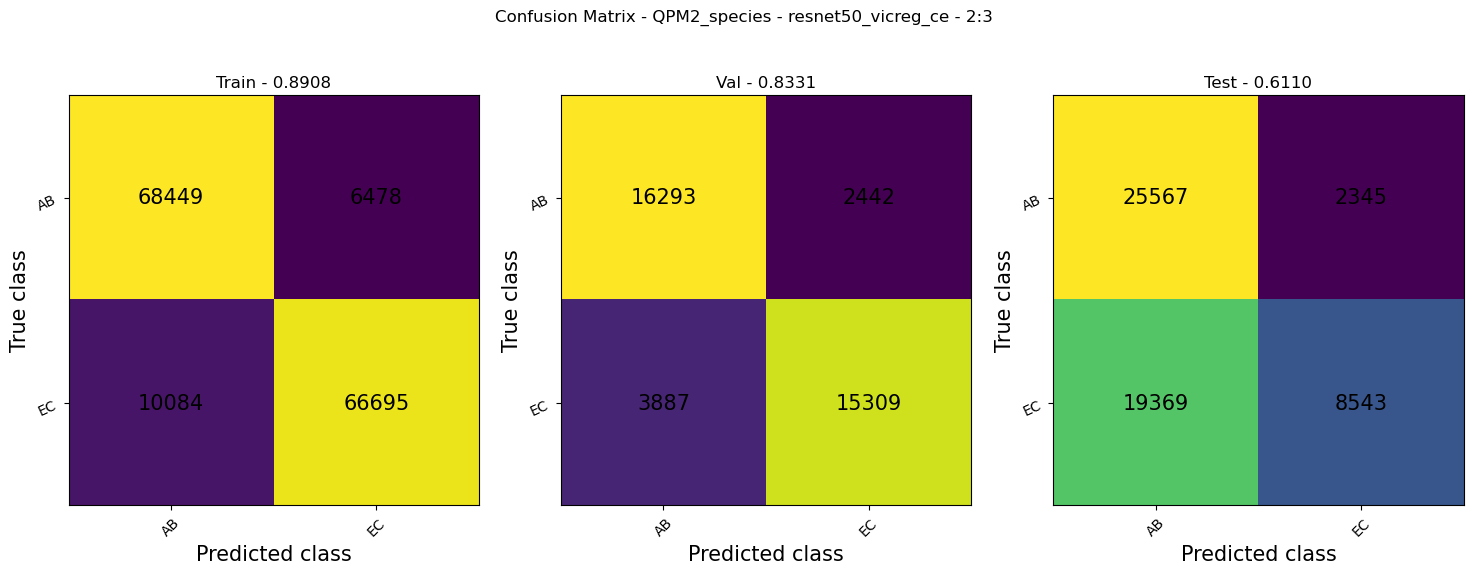

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)
(55824, 2) (41868, 2)


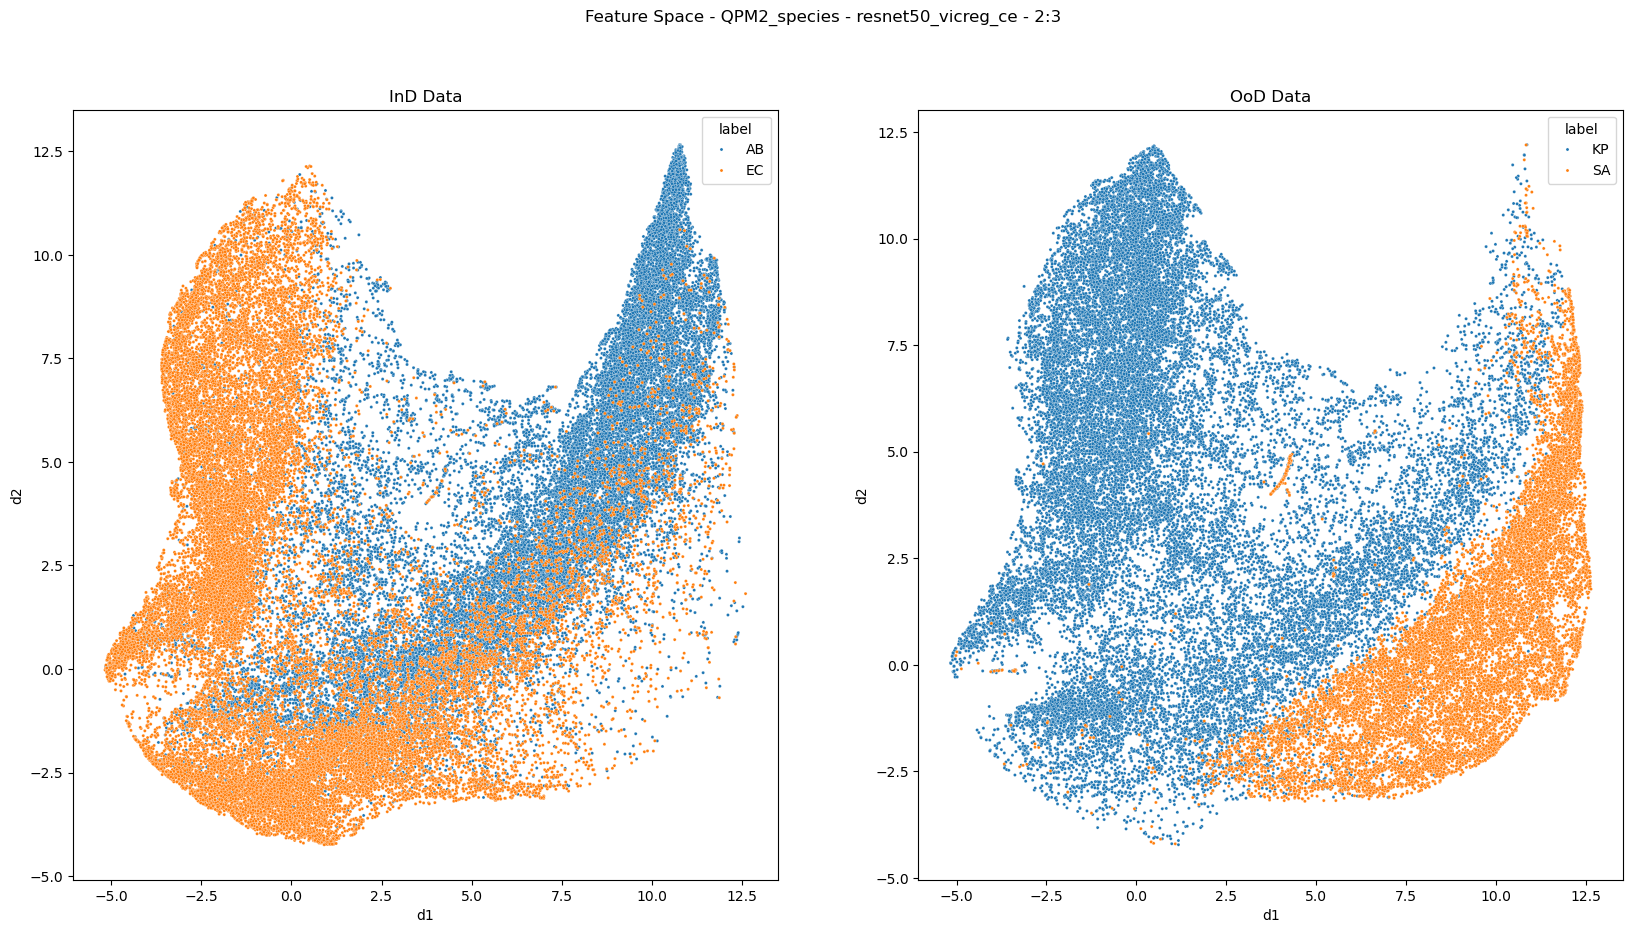

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

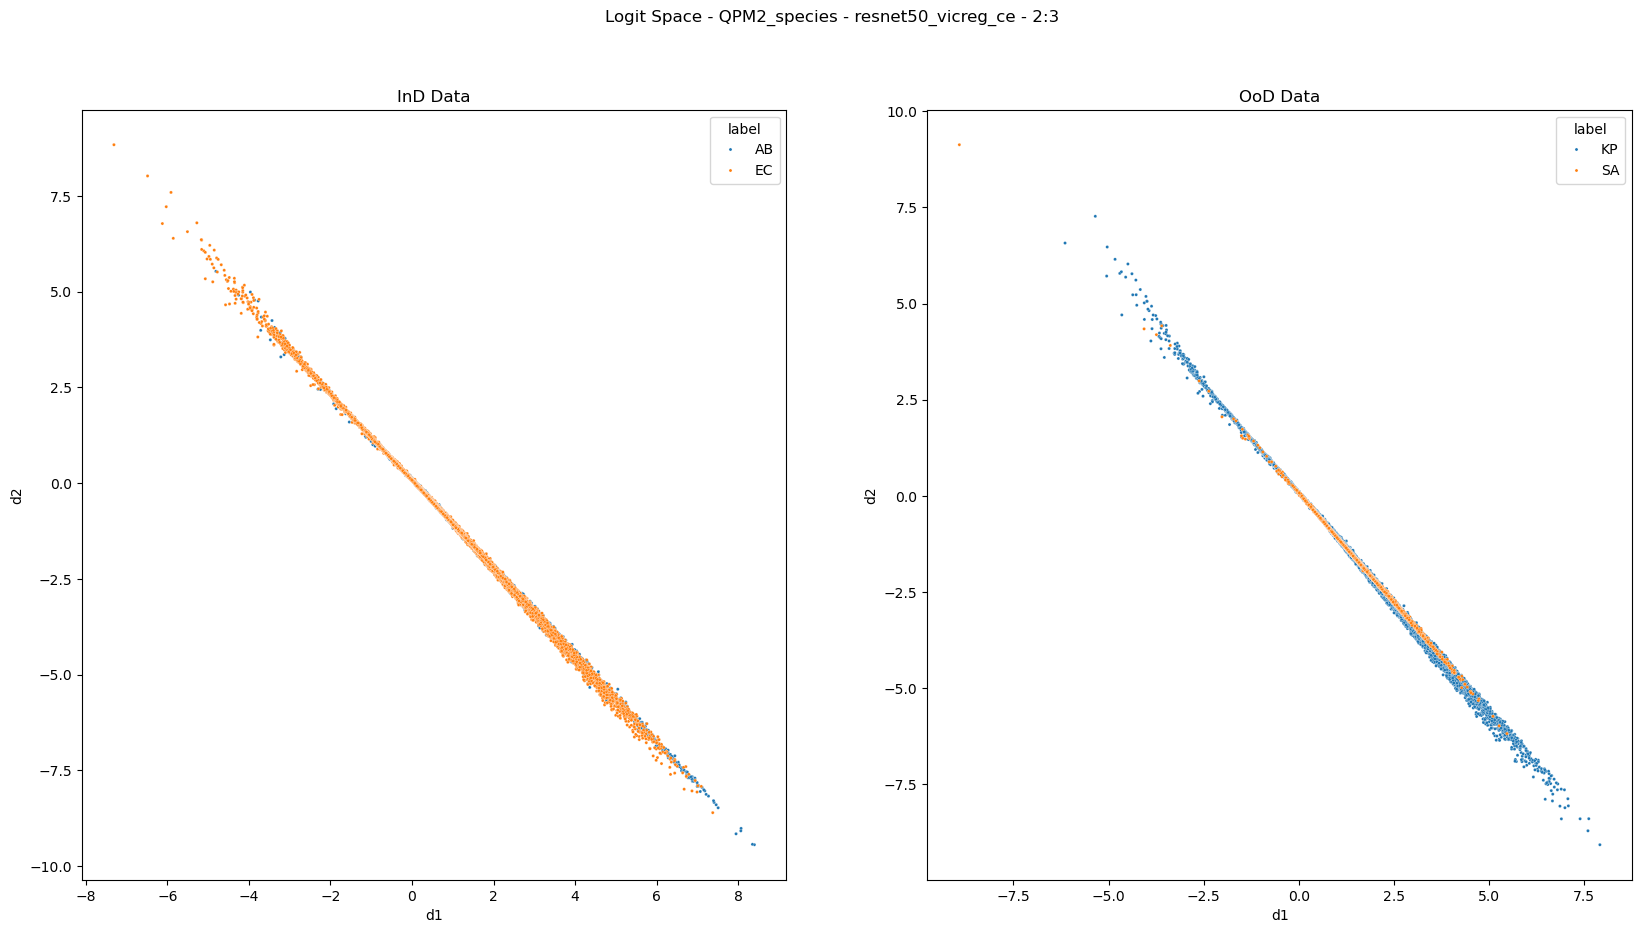

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

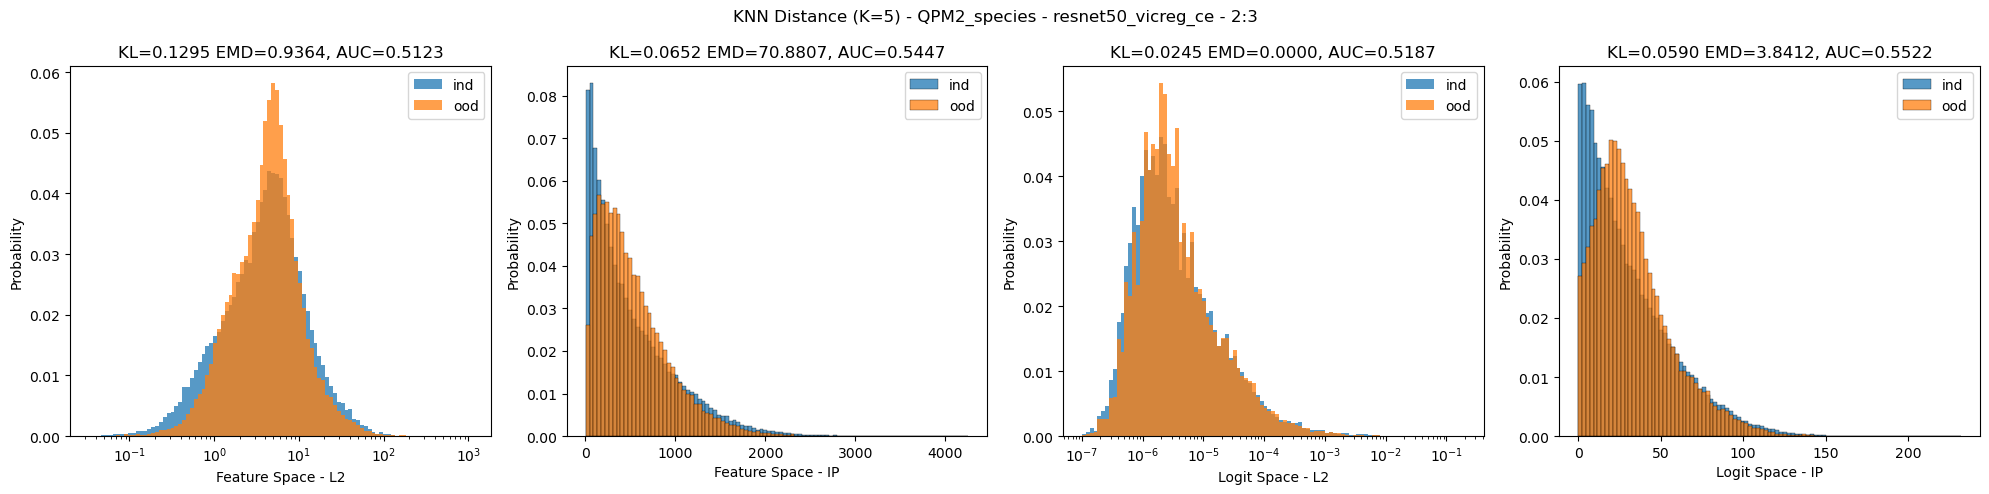

In [15]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

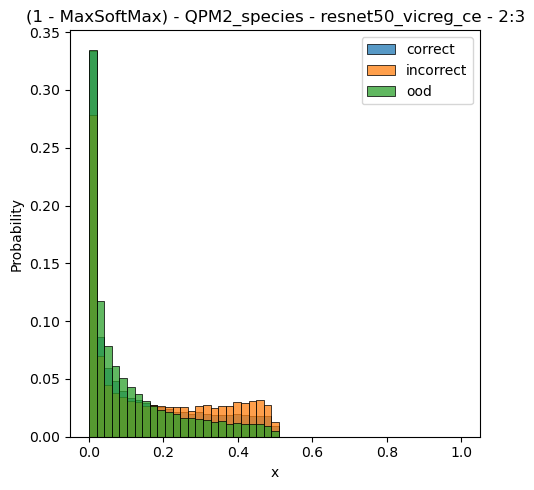

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)